Use GPU if available

In [1]:
import torch

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
    )

print(f"Using {device} device")

Using cuda device


Load CIFAR10 dataset

In [2]:
import torchvision
import torchvision.transforms as transforms

MINI_BATCH_SIZE = 128

transform = transforms.Compose(
    [transforms.ToTensor()]
    )

trainset = torchvision.datasets.CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=transform
    )

trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=MINI_BATCH_SIZE,
    shuffle=True, # reshuffle data at every epoch
    num_workers=2
    )

testset = torchvision.datasets.CIFAR10(
    root="./data",
    train=False,
    download=True,
    transform=transform
    )

testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=MINI_BATCH_SIZE,
    shuffle=False,
    num_workers=2
    )

classes = ("plane", "car", "bird", "cat", "deer",
           "dog", "frog", "horse", "ship", "truck")

Files already downloaded and verified
Files already downloaded and verified


Define the neural network

In [3]:
import torch.nn as nn
import torch.nn.functional as F

def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = conv_block(3, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.out = nn.Linear(512, 10)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)

        x = self.res1(x) + x
        
        x = self.conv3(x)
        x = self.conv4(x)
        
        x = self.res2(x) + x
        
        x = F.max_pool2d(x, kernel_size=4)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.out(x)

        return x

Function definitions to train, test, and freeze the parameters of the neural network

In [4]:
import matplotlib.pyplot as plt
import numpy as np

''' Train the neural network using backpropagation with cross entropy as the loss function '''
def train_nn(net: nn.Module, epochs: int, optimizer: torch.optim.Optimizer):
  print(f'Initialising training ...')
  print(f'- Epochs: {epochs}')
  print(f'- Mini batch size: {MINI_BATCH_SIZE}')
  print(f'- Optimiser: {optimizer}')
  print(f'- Loss function: {F.cross_entropy.__name__}')

  evaluation_loss_track = []
  running_loss_track = []
  accuracy_track = []

  # loop over the dataset multiple times
  for epoch in range(epochs):
    running_loss = 0

    # loop over the dataset and get mini-batch
    for mini_batch in trainloader:
      images = mini_batch[0].to(device)
      labels = mini_batch[1].to(device)

      optimizer.zero_grad() # zero the parameter gradients

      preds = net(images) # forward mini-batch

      loss = F.cross_entropy(preds, labels) # calculate loss
      loss.backward() # calculate gradients with respect to each weight
      optimizer.step() # update weights

      running_loss += loss.item()

      # track
      evaluation_loss_track.append(loss.item())

    accuracy = test_nn(net=net, verbose=False)
    print(f'\nEpoch {epoch} finished -- Running loss {running_loss} -- Accuracy {accuracy}')

    # track
    running_loss_track.append(running_loss)
    accuracy_track.append(accuracy)

  # plot
  fig, ax1 = plt.subplots()

  ax1.set_xlabel('Iterations over entire dataset (Epoch)')
  
  ax1.set_ylabel('Accuracy', color='b')
  ax1.plot(np.array(accuracy_track), '--b', label='Accuracy', linewidth=0.5)

  ax2 = ax1.twinx()
  ax2.set_ylabel('Running loss per epoch', color='r')
  ax2.plot(np.array(running_loss_track), '--r', label='Loss per epoch', linewidth=0.5)

  fig.tight_layout()
  fig.legend()
  plt.show()

''' Test the neural network '''
def test_nn(net: nn.Module, verbose: bool):
    # test the neural network
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            images = data[0].to(device)
            labels = data[1].to(device)

            # calculate outputs by running images through the network
            outputs = net(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct // total

    if verbose:
        print('Testing on 10,000 test images ...')
        print(f'- Correct: {correct}')
        print(f'- Total: {total}')
        print(f'- Accuracy: {accuracy}')

    return accuracy

''' Freeze all the parameters except the last layer and randomize last layer '''
def freeze_parameters(net: nn.Module):
    # freeze all the parameters in the NN
    for param in net.parameters():
        param.requires_grad = False

    # unfreeze all the parameters from the last layer and randomise the weights
    for param in net.out.parameters():
        param.requires_grad = True
        param.data = torch.rand(param.size(), device=device)

Train the entire neural network

Initialising training ...
- Epochs: 15
- Mini batch size: 128
- Optimiser: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0.0
    nesterov: False
    weight_decay: 0
)
- Loss function: cross_entropy

Epoch 0 finished -- Running loss 726.2720959186554 -- Accuracy 50

Epoch 1 finished -- Running loss 459.4628681540489 -- Accuracy 58

Epoch 2 finished -- Running loss 350.14074742794037 -- Accuracy 70

Epoch 3 finished -- Running loss 278.19030770659447 -- Accuracy 71

Epoch 4 finished -- Running loss 219.409139752388 -- Accuracy 75

Epoch 5 finished -- Running loss 161.04677732288837 -- Accuracy 76

Epoch 6 finished -- Running loss 117.04660829901695 -- Accuracy 79

Epoch 7 finished -- Running loss 67.62799846380949 -- Accuracy 78

Epoch 8 finished -- Running loss 32.33484409749508 -- Accuracy 81

Epoch 9 finished -- Running loss 14.205308748409152 -- Accuracy 82

Epoch 10 finished -- Running loss 7.16856

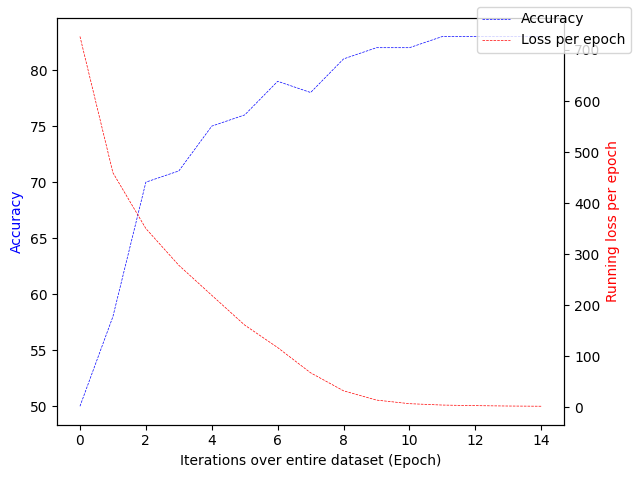

Testing on 10,000 test images ...
- Correct: 8335
- Total: 10000
- Accuracy: 83


83

In [5]:
import torch

# create a new neural network
torch.manual_seed(1)
net = Net()
net.to(device)

optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.0)

train_nn(net=net, epochs=15, optimizer=optimizer)
test_nn(net=net, verbose=True)

Save the neural network model

In [6]:
# PATH = "./nn-models/cifar10-nn-model"
# torch.save(net.state_dict(), PATH)

Load the pre-trained neural network model

In [7]:
PATH = "./nn-models/cifar10-nn-model"

# load the pretrained NN model
net = Net()
net.load_state_dict(torch.load(PATH))
net.to(device=device)

test_nn(net=net, verbose=True)

Testing on 10,000 test images ...
- Correct: 8335
- Total: 10000
- Accuracy: 83


83